In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.accelerometer._02_preprocess import AccelerometerPreprocessor
from src.accelerometer.config import *
from src.accelerometer._01_get_data import DataLoader, MultiDataLoader

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [4]:
hc_files = [
    DATA_DIR / "900_1_accelerometer.pkl", # Healthy control example
    DATA_DIR / "901_1_accelerometer.pkl"  # Healthy control example
]

pd_off_file_1 = DATA_DIR / "801_1_accelerometer.pkl" # PD patient OFF medication
pd_on_file_1 = DATA_DIR / "801_2_accelerometer.pkl"  # Same PD patient ON medication

pd_off_file_2 = DATA_DIR / "802_1_accelerometer.pkl" 
pd_on_file_2 = DATA_DIR / "802_2_accelerometer.pkl"  


In [5]:
hc_preprocessor_1 = AccelerometerPreprocessor([hc_files[0]], sampling_freq=SAMPLING_FREQ)
hc_preprocessor_2 = AccelerometerPreprocessor([hc_files[1]], sampling_freq=SAMPLING_FREQ)

pd_preprocessor_off_1 = AccelerometerPreprocessor([pd_off_file_1], sampling_freq=SAMPLING_FREQ)
pd_preprocessor_on_1 = AccelerometerPreprocessor([pd_on_file_1], sampling_freq=SAMPLING_FREQ)

pd_preprocessor_off_2 = AccelerometerPreprocessor([pd_off_file_2], sampling_freq=SAMPLING_FREQ)
pd_preprocessor_on_2 = AccelerometerPreprocessor([pd_on_file_2], sampling_freq=SAMPLING_FREQ)

In [6]:
hc1_raw = hc_preprocessor_1.multi_data[0].copy()
hc2_raw = hc_preprocessor_2.multi_data[0].copy()
pd_off_raw_1 = pd_preprocessor_off_1.multi_data[0].copy()
pd_on_raw_1 = pd_preprocessor_on_1.multi_data[0].copy()
pd_off_raw_2 = pd_preprocessor_off_2.multi_data[0].copy()
pd_on_raw_2 = pd_preprocessor_on_2.multi_data[0].copy()

In [7]:
def run_full_pipeline(preprocessor):
    preprocessor._remove_drift(window_size=DRIFT_WINDOW_SIZE)
    preprocessor._bandpass_filter(lowcut=BANDPASS_LOWCUT, highcut=BANDPASS_HIGHCUT, freq_resolution=BANDPASS_FREQ_RESOLUTION)
    preprocessor._segment_data(window_size=SEGMENT_WINDOW_SIZE, percent_overlap=SEGMENT_PERCENT_OVERLAP)
    preprocessor._detect_peak_frequency(low_freq=PEAK_LOW_FREQ, high_freq=PEAK_HIGH_FREQ, ar_order=AR_ORDER, prominence_percent=PROMINENCE_PERCENT)
    preprocessor._map_windows_to_timesteps()
    preprocessor._smooth_signal(smoothing_window=SMOOTHING_WINDOW)
    preprocessor._multiply()
    preprocessor._thresholding(threshold=FEATURE_THRESHOLD)
    preprocessor._feature_extraction(threshold=FEATURE_EXTRACTION_DURATION_THRESHOLD)


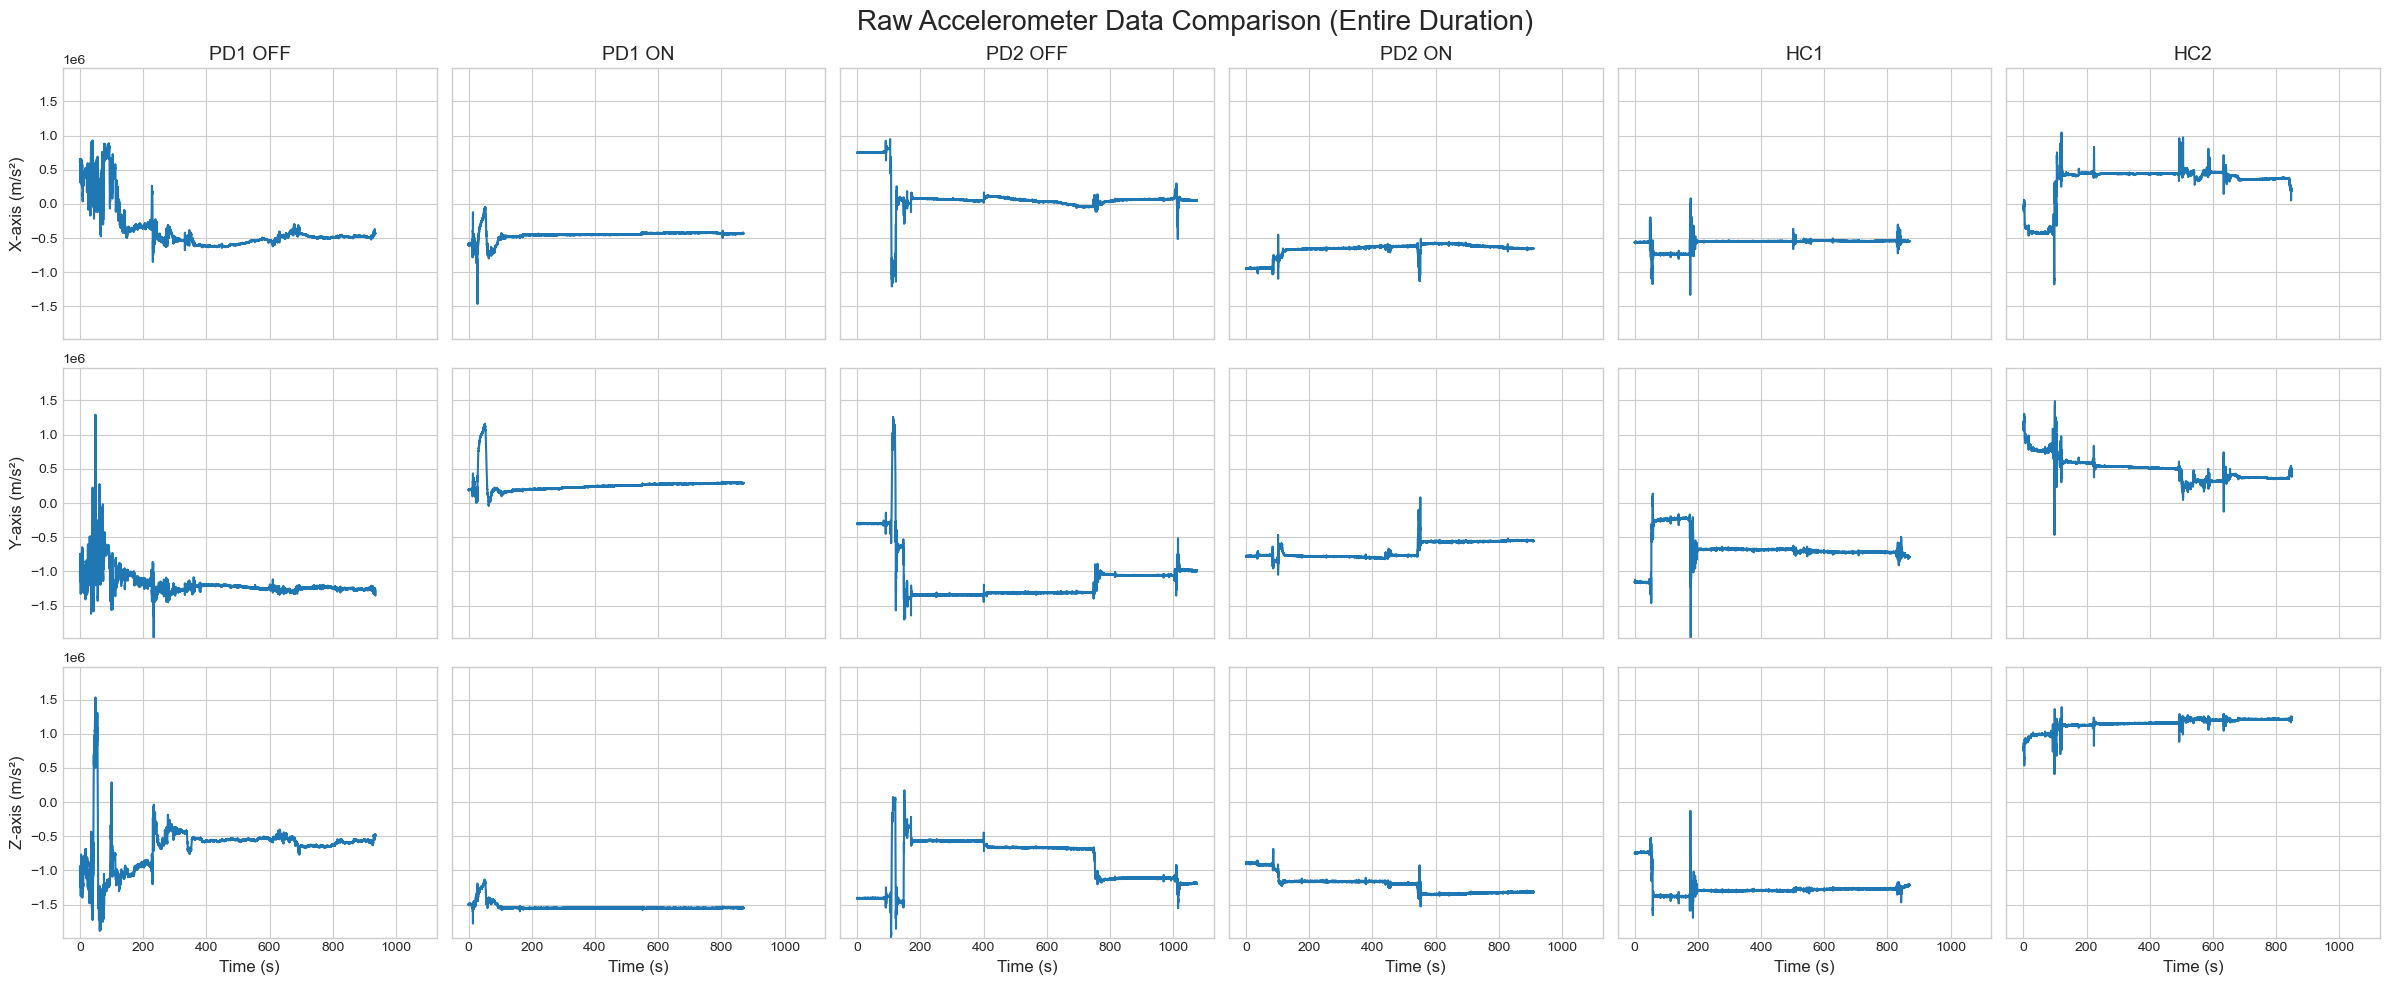

In [8]:
data_sets = [
    (pd_off_raw_1, 'PD1 OFF'),
    (pd_on_raw_1, 'PD1 ON'),
    (pd_off_raw_2, 'PD2 OFF'),
    (pd_on_raw_2, 'PD2 ON'),
    (hc1_raw, 'HC1'),
    (hc2_raw, 'HC2'),
]

fs = SAMPLING_FREQ

max_abs_values = np.zeros(3)
for data, _ in data_sets:
    for row_idx in range(3):
        max_abs_values[row_idx] = max(max_abs_values[row_idx], np.max(np.abs(data[row_idx])))

fig, axs = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(24, 10))
fig.suptitle(f"Raw Accelerometer Data Comparison (Entire Duration)", fontsize=20)

for col_idx, (data, title) in enumerate(data_sets):
    timesteps = np.arange(data.shape[1]) / fs
    for row_idx, axis_label in enumerate(['X-axis', 'Y-axis', 'Z-axis']):
        axs[row_idx, col_idx].plot(timesteps, data[row_idx])
        axs[row_idx, col_idx].set_ylim(-max_abs_values[row_idx], max_abs_values[row_idx])
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(title, fontsize=14)
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"{axis_label} (m/s²)", fontsize=12)
        if row_idx == 2:
            axs[row_idx, col_idx].set_xlabel('Time (s)', fontsize=12)

plt.tight_layout()
plt.show()

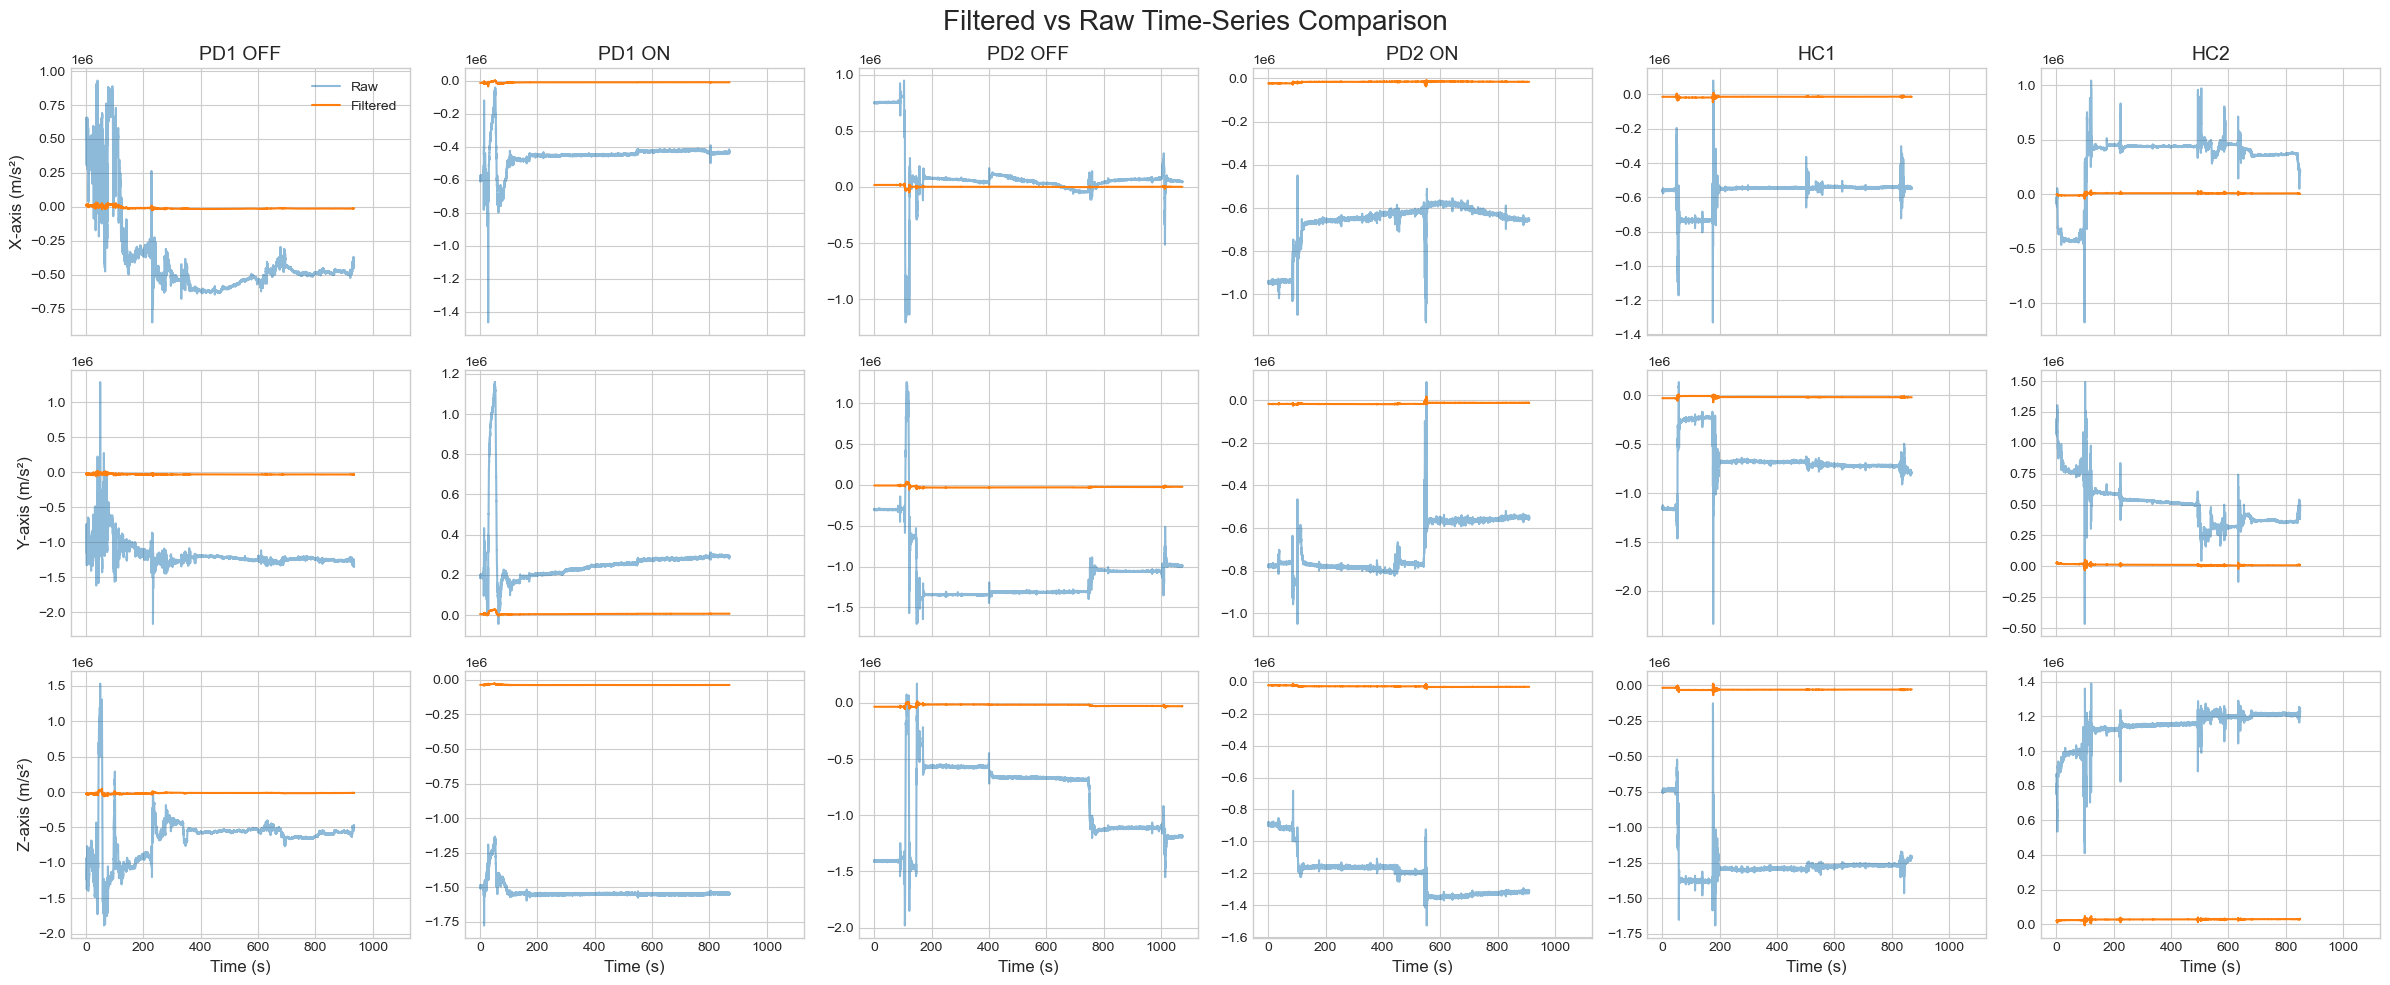

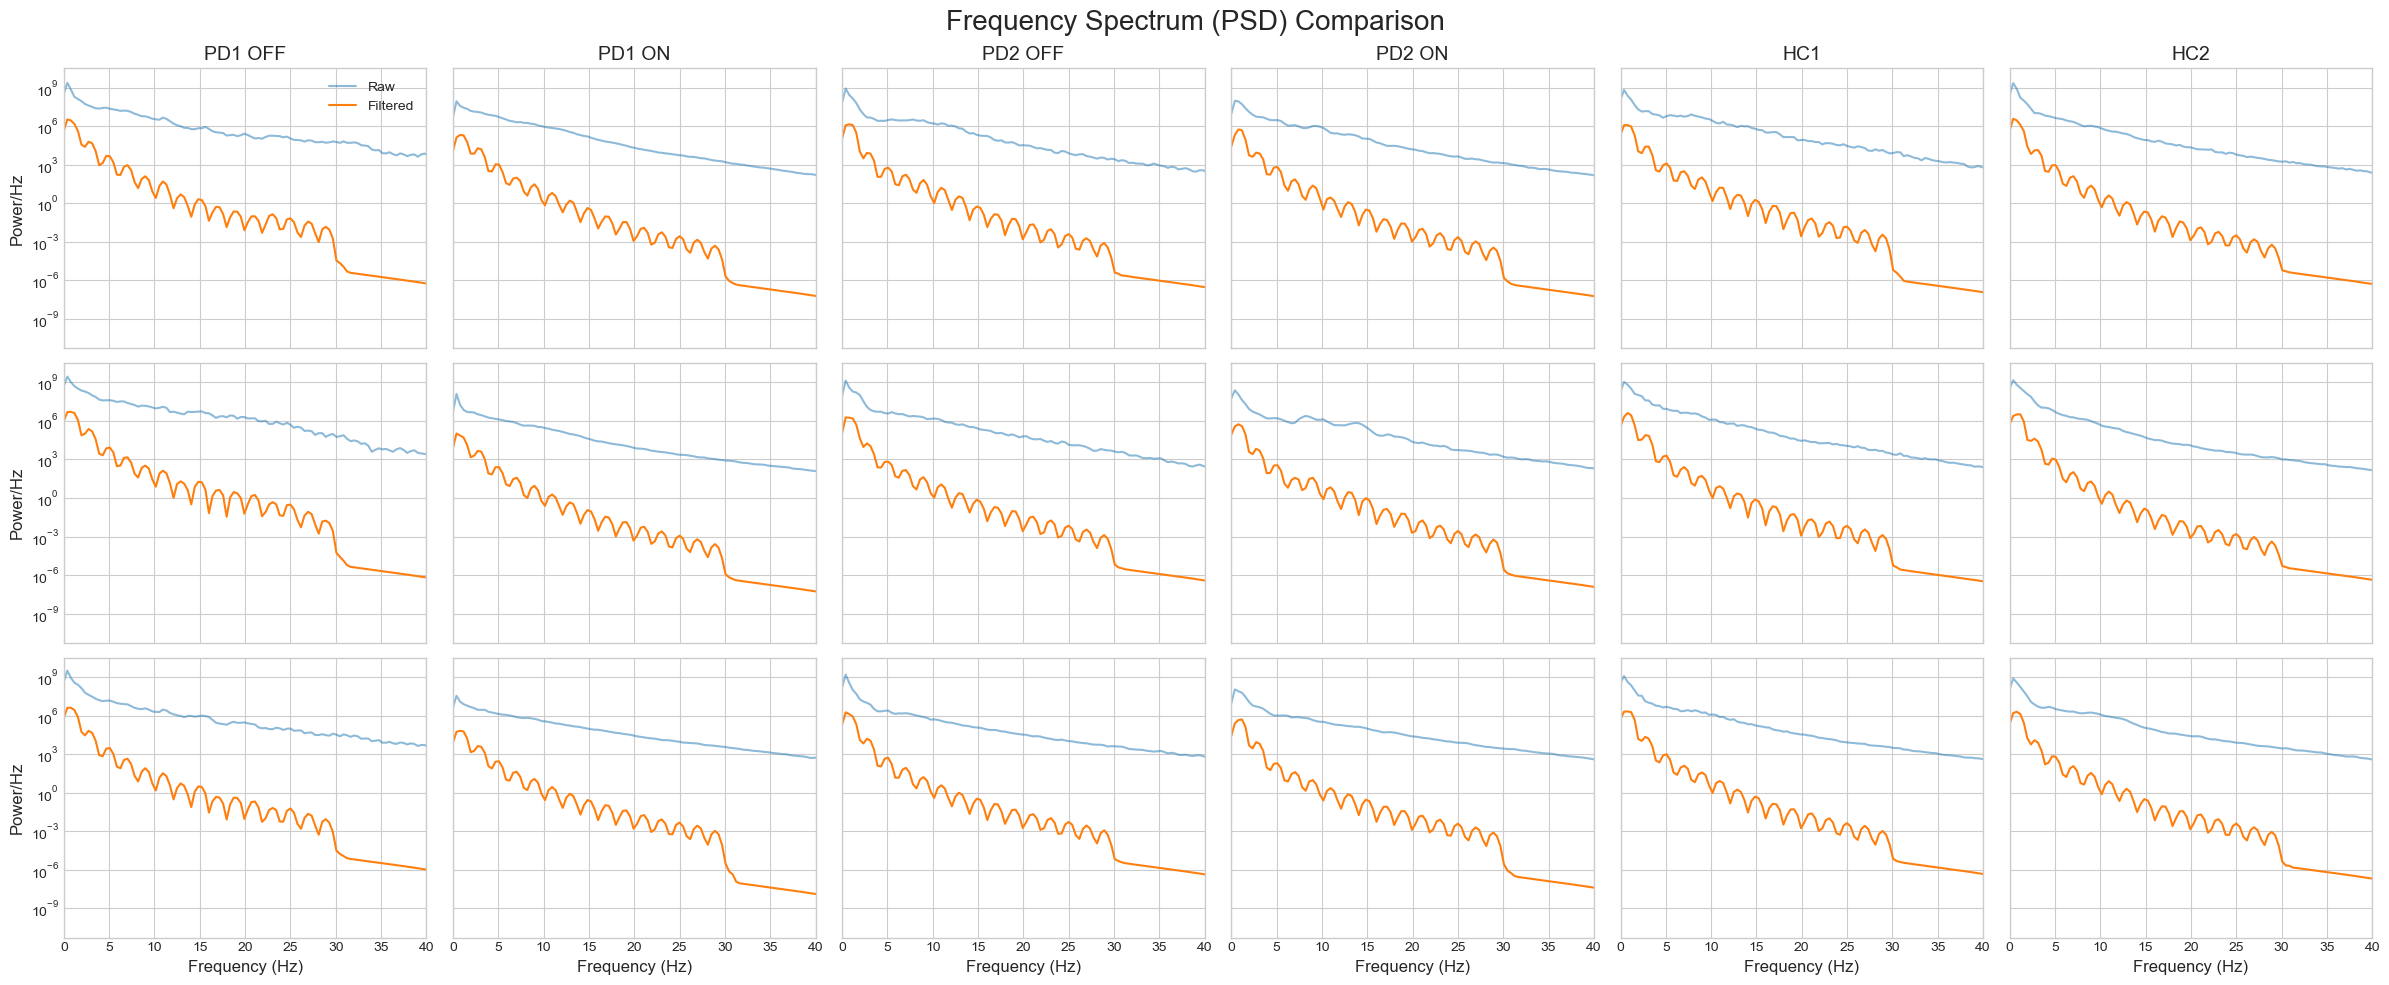

In [12]:
from scipy.signal import welch

def compute_psd(signal, fs):
    f, pxx = welch(signal, fs, nperseg=256, scaling='density')
    return f, pxx

fig_ts, axs_ts = plt.subplots(3, 6, sharex=True, sharey=False, figsize=(24, 10))
fig_ts.suptitle("Filtered vs Raw Time-Series Comparison", fontsize=20)

fig_psd, axs_psd = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(24, 10))
fig_psd.suptitle("Frequency Spectrum (PSD) Comparison", fontsize=20)

# Get a valid file path from one of the preprocessors to use as a placeholder
placeholder_file_path = pd_preprocessor_off_1.file_paths

# Create a single temporary preprocessor instance with a valid file path
# The data loaded by this step will be immediately overridden in the loop
temp_preprocessor = AccelerometerPreprocessor(placeholder_file_path, sampling_freq=SAMPLING_FREQ)

for col_idx, (raw_data, title) in enumerate(data_sets):
    
    # Manually set the preprocessor's multi_data[0] to the raw data we loaded at the beginning
    temp_preprocessor.multi_data[0] = raw_data.copy()
    
    temp_preprocessor._remove_drift(window_size=DRIFT_WINDOW_SIZE)
    temp_preprocessor._bandpass_filter(lowcut=BANDPASS_LOWCUT, highcut=BANDPASS_HIGHCUT, freq_resolution=BANDPASS_FREQ_RESOLUTION)
    filtered_data = temp_preprocessor.multi_data[0]

    timesteps = np.arange(raw_data.shape[1]) / SAMPLING_FREQ
    
    for row_idx, axis_label in enumerate(['X', 'Y', 'Z']):
        # Time-Series plot
        axs_ts[row_idx, col_idx].plot(timesteps, raw_data[row_idx], label='Raw', alpha=0.5)
        axs_ts[row_idx, col_idx].plot(timesteps, filtered_data[row_idx], label='Filtered')
        if row_idx == 0:
            axs_ts[row_idx, col_idx].set_title(title, fontsize=14)
        if col_idx == 0:
            axs_ts[row_idx, col_idx].set_ylabel(f"{axis_label}-axis (m/s²)", fontsize=12)
        if row_idx == 2:
            axs_ts[row_idx, col_idx].set_xlabel('Time (s)', fontsize=12)

        # PSD plot
        f_raw, pxx_raw = compute_psd(raw_data[row_idx], SAMPLING_FREQ)
        f_filtered, pxx_filtered = compute_psd(filtered_data[row_idx], SAMPLING_FREQ)
        axs_psd[row_idx, col_idx].semilogy(f_raw, pxx_raw, label='Raw', alpha=0.5)
        axs_psd[row_idx, col_idx].semilogy(f_filtered, pxx_filtered, label='Filtered')
        axs_psd[row_idx, col_idx].set_xlim(0, 40)
        if row_idx == 0:
            axs_psd[row_idx, col_idx].set_title(title, fontsize=14)
        if col_idx == 0:
            axs_psd[row_idx, col_idx].set_ylabel(f"Power/Hz", fontsize=12)
        if row_idx == 2:
            axs_psd[row_idx, col_idx].set_xlabel('Frequency (Hz)', fontsize=12)

axs_ts[0, 0].legend()
axs_psd[0, 0].legend()
fig_ts.tight_layout()
fig_psd.tight_layout()
plt.show()

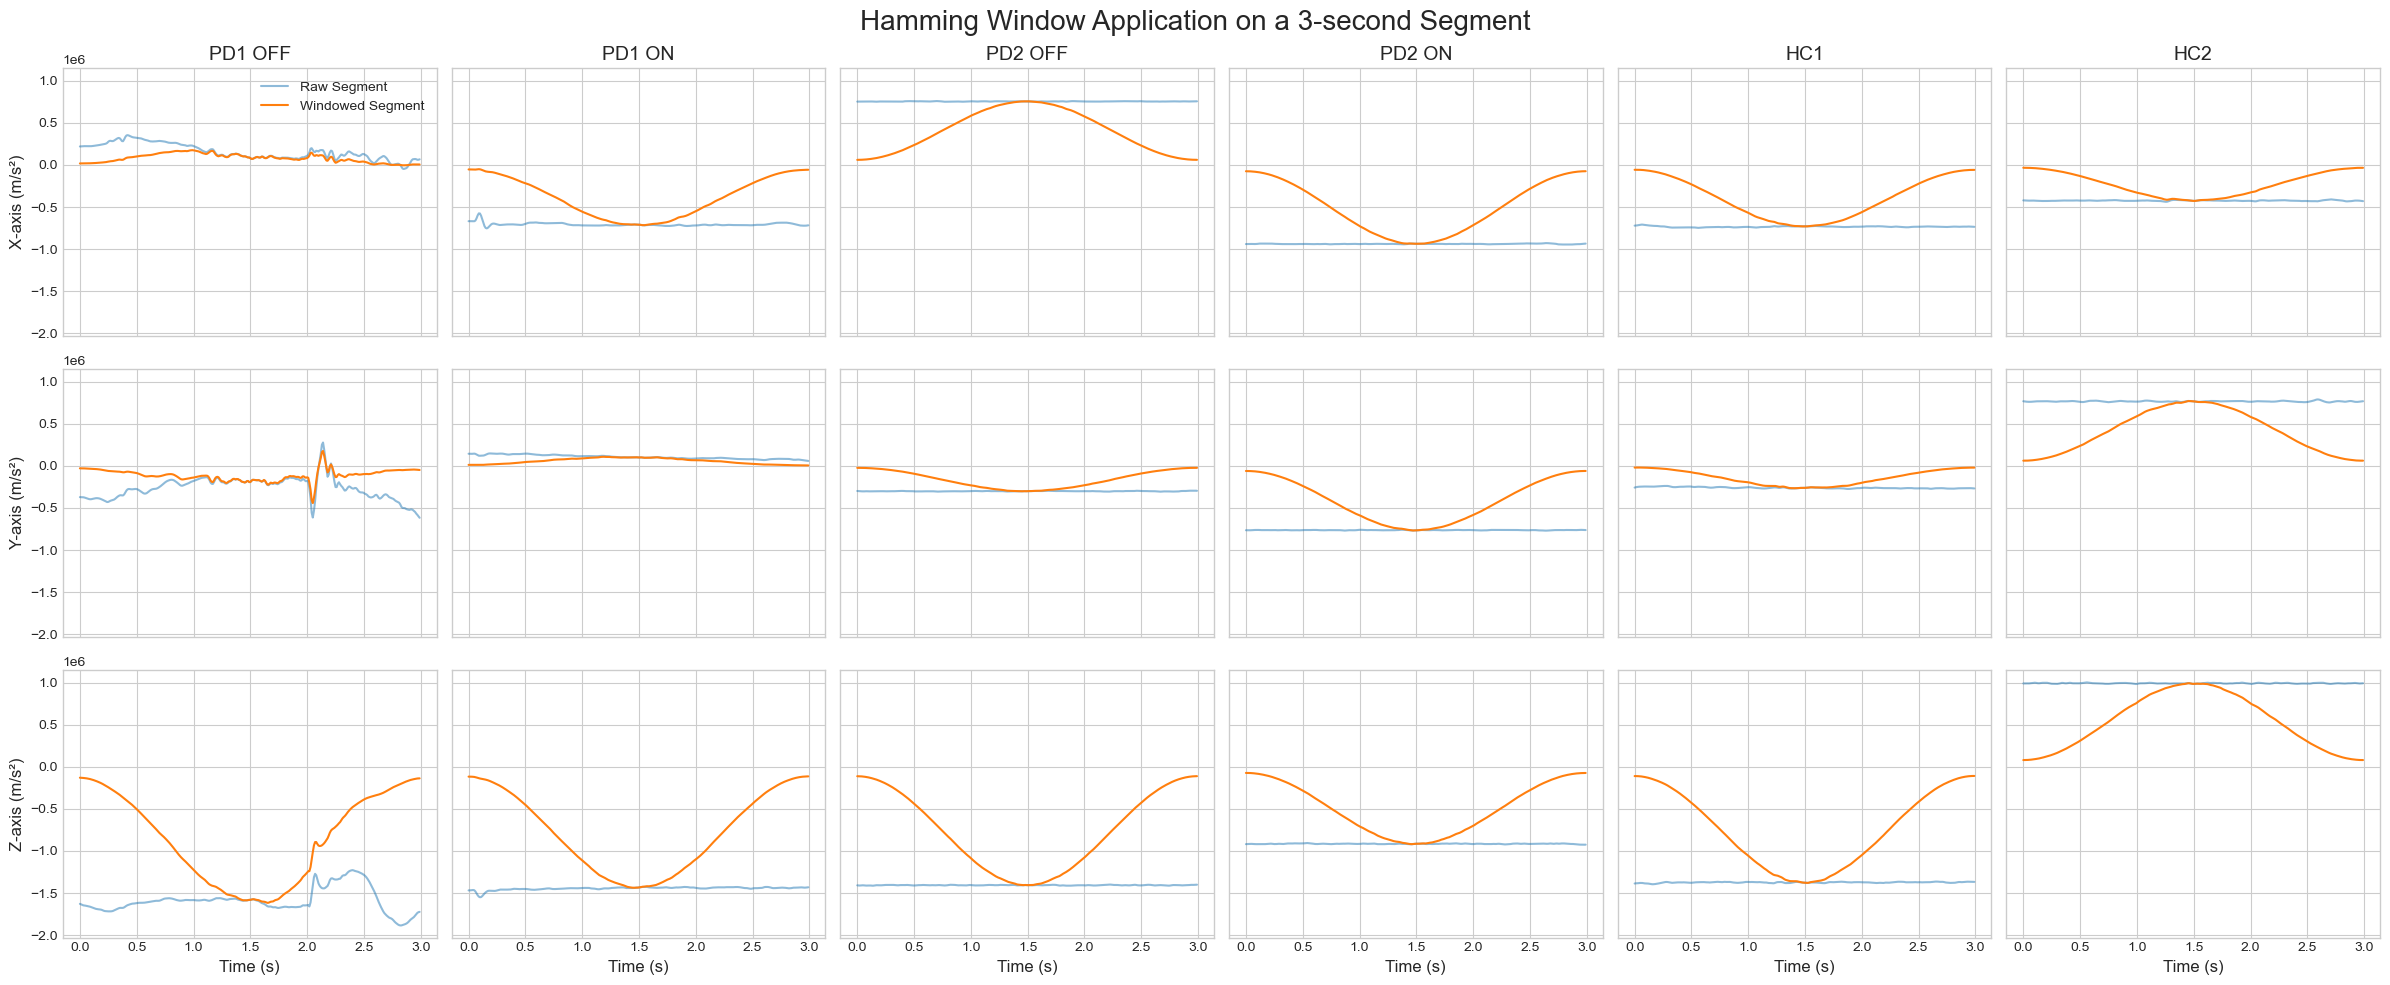

In [ ]:
segment_length_s = 3
segment_start_s = 60
segment_end_s = segment_start_s + segment_length_s
fs = SAMPLING_FREQ

fig, axs = plt.subplots(3, 6, sharex=True, sharey=True, figsize=(24, 10))
fig.suptitle(f"Hamming Window Application on a 3-second Segment", fontsize=20)

for col_idx, (raw_data, title) in enumerate(data_sets):
    start_idx = int(segment_start_s * fs)
    end_idx = int(segment_end_s * fs)
    
    # Use the raw_data variable directly for the raw segment
    segment_data = raw_data[:, start_idx:end_idx]
    hamming_window = np.hamming(segment_data.shape[1])
    windowed_segment = segment_data * hamming_window[np.newaxis, :]
    
    timesteps = np.arange(segment_data.shape[1]) / fs
    
    for row_idx, axis_label in enumerate(['X', 'Y', 'Z']):
        axs[row_idx, col_idx].plot(timesteps, segment_data[row_idx], label='Raw Segment', alpha=0.5)
        axs[row_idx, col_idx].plot(timesteps, windowed_segment[row_idx], label='Windowed Segment')
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(title, fontsize=14)
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"{axis_label}-axis (m/s²)", fontsize=12)
        if row_idx == 2:
            axs[row_idx, col_idx].set_xlabel('Time (s)', fontsize=12)

axs[0, 0].legend()
plt.tight_layout()
plt.show()